In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in Enterococcus data (BacDrop)

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/enterococcus_data_processed.h5ad")


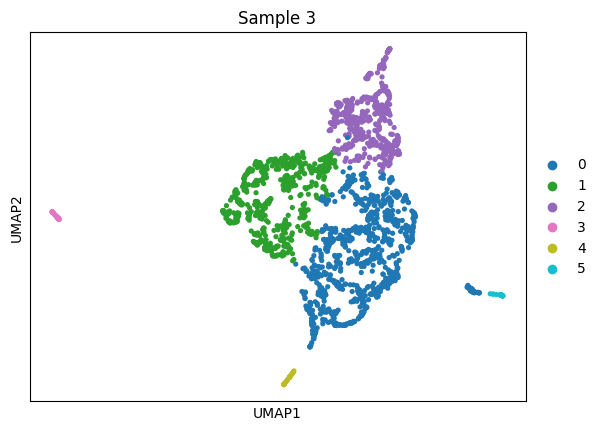

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB withou

In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,means,variances,variances_norm,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-FCF09_RS00685,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01380,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01405,14,0.006626,0.006604,99.337435,14.0,2.708050,14,0.006582,False,0.308029,...,0.006626,0.006585,0.961788,0.006626,0.006582,4.389925e-05,poi,0.006638,inf,0.002661
cds-FCF09_RS01745,8,0.003786,0.003779,99.621391,8.0,2.197225,8,0.003772,False,0.179019,...,0.003786,0.003774,0.972293,0.003786,0.003772,1.433445e-05,poi,0.004754,inf,0.204965
cds-FCF09_RS02225,29,0.014198,0.014098,98.627544,30.0,3.433987,29,0.014943,False,0.435907,...,0.014198,0.014950,1.007335,0.014198,0.014943,-7.449434e-04,nb,0.014198,0.258519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-WP_162166412.1,3,0.001420,0.001419,99.858022,3.0,1.386294,3,0.001418,False,0.070689,...,0.001420,0.001418,0.987596,0.001420,0.001418,2.015782e-06,poi,0.006547,inf,0.782912
cds-WP_162166413.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171002443.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171918352.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488


## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 1.503630210527763
Factor: 2 - Error: 1.5299540490381105
Factor: -0.618034 - Error: 1.3562923035493994
Factor: -3.2360680251559995 - Error: 1.5465837139297482
Factor: -0.618034 - Error: 1.3562923035493994
Factor: -1.6180340106330766 - Error: 1.4746052260051346
Factor: -8.975660048538003e-09 - Error: 1.4910606636811479
Factor: -1.0000000140614738 - Error: 1.506826936710279
Factor: -0.3819660224040571 - Error: 1.483761592504095
Factor: -0.763932034346665 - Error: 1.483810155928174
Factor: -0.5278640565089083 - Error: 1.5137783721125997
Factor: -0.6737620900462387 - Error: 1.508613901160423
Factor: -0.5835921464627822 - Error: 1.4607655859800144
Factor: -0.6393202361998824 - Error: 1.5342586901960598
Factor: -0.6048783826273846 - Error: 1.4267468164760415
Factor: -0.6261646187091867 - Error: 1.3874735533490634
Factor: -0.6130090013230954 - Error: 1.4615263666115474
Factor: -0.6211396199871794 - Error: 1.399312971708034
Factor: -0.6161146213051275 - Error: 1.4061095194713

In [8]:
importlib.reload(cd)
xmin=1

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

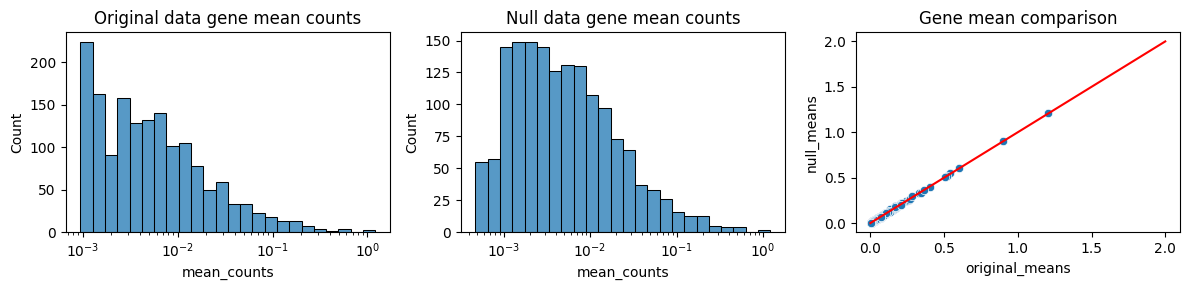

SignificanceResult(statistic=0.9709849275161246, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

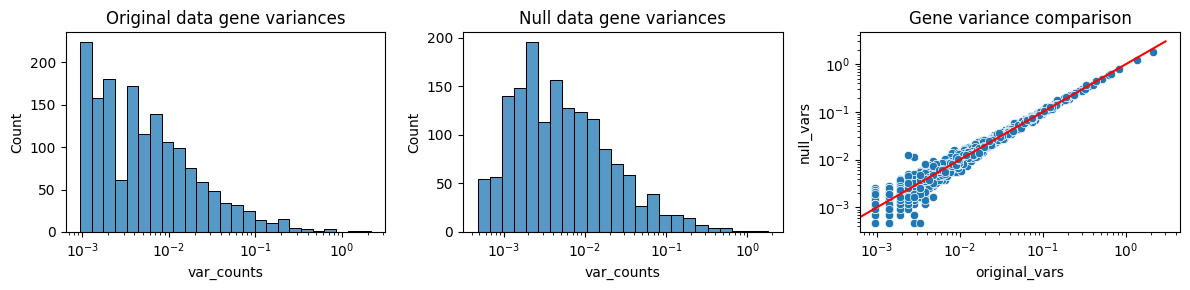

SignificanceResult(statistic=0.9670098990995815, pvalue=0.0)
[[1.         0.99654643]
 [0.99654643 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

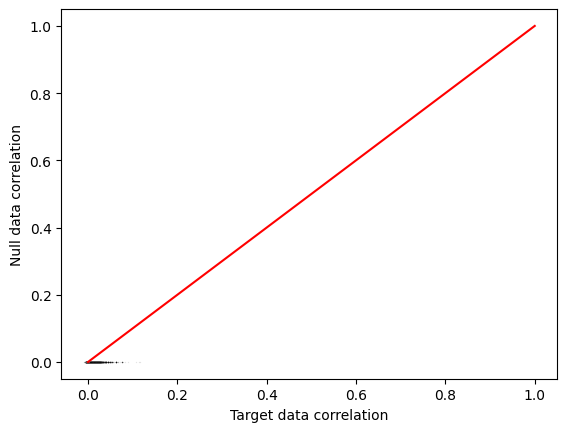

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


25


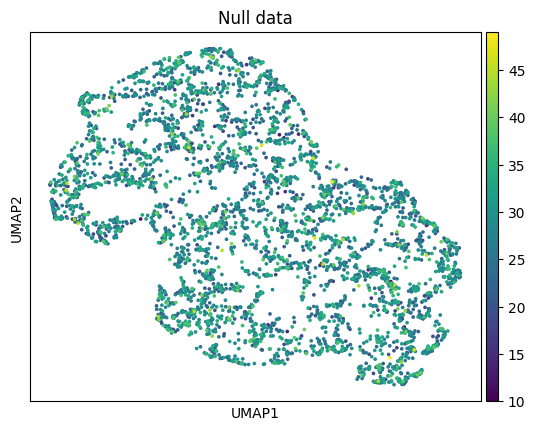

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_enterococcus.h5ad")

In [19]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_enterococcus.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [20]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 1
resolution: 0.11, clusters: 3
resolution: 0.105, clusters: 2
split 1/1 - Resolution 0.105
Best split: No. 0 - seed: 979 - minimal p-value: 1.1686908833839338e-10


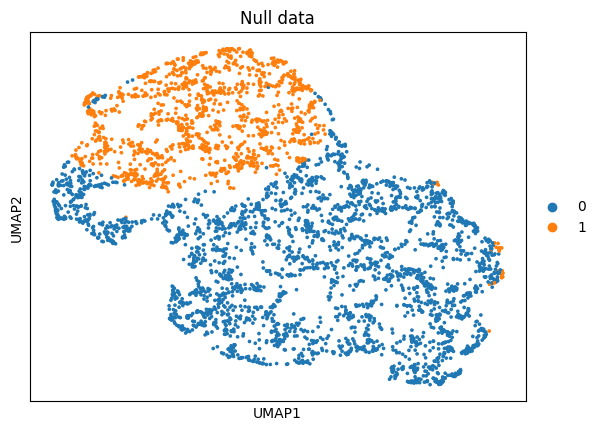

In [21]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [22]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_enterococcus.h5ad")

In [23]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.7551020408163265
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 0; Minimum q value: 0.5714285714285714
Cluster 5 - DE genes: 0; Minimum q value: 0.1
Cluster 4 - DE genes: 48; Minimum q value: 0.022727272727272728
Cluster 3 - DE genes: 63; Minimum q value: 0.018867924528301886


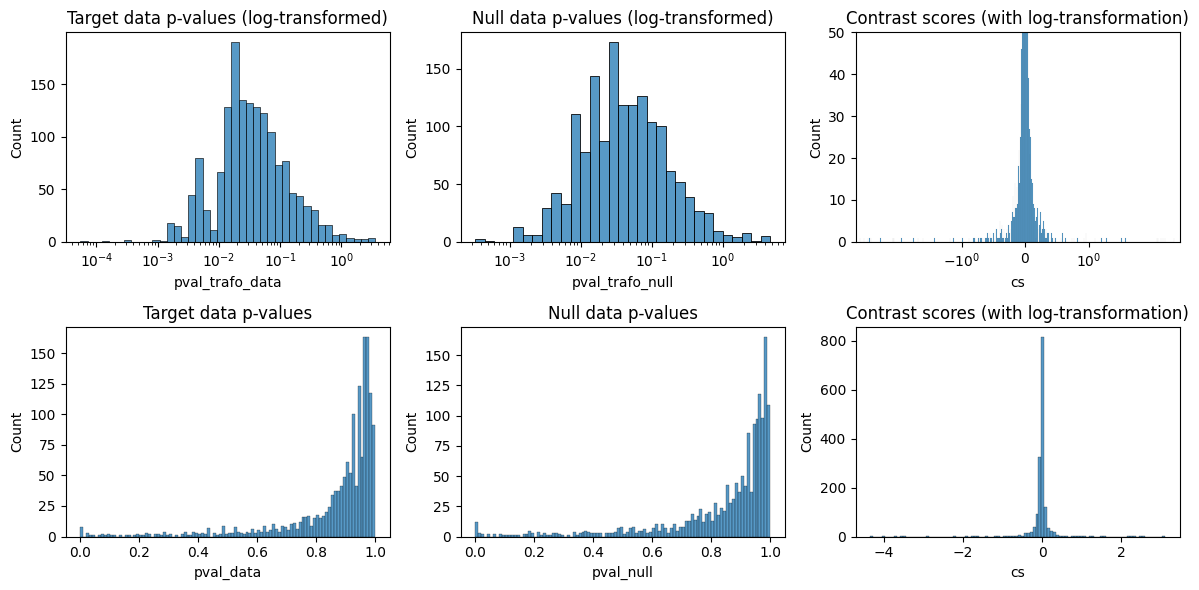

In [34]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [25]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.755102      49
0.764706       2
0.830189       2
0.888889       1
0.890909       1
0.913793       3
0.915493      13
0.958333       1
0.972603       1
1.000000    1508
Name: q, dtype: int64

cluster 1
1.0    1581
Name: q, dtype: int64

cluster 2
0.571429     21
0.616071     91
0.637168      1
0.649123      1
0.649573      3
0.655462      2
0.701613      5
0.712000      1
0.722222      1
0.755906      1
0.781250      1
0.790698      1
0.795455      3
0.796992      1
0.798507      1
0.800000      1
0.802395     32
0.803571      1
0.807018      3
0.813953      1
0.827027     13
0.827957      1
0.828877      1
0.830846     14
0.831683      1
0.837438      1
0.839024      2
0.863436     22
0.873362      2
0.873913      1
0.883117      1
0.883621      1
0.889027    570
0.891656      1
0.896766      1
0.896894      1
0.897022      1
1.000000    775
Name: q, dtype: int64

cluster 5
0.100000     10
0.181818      1
0.461538      2
0.636364      9
0.821918     51
0.822785      6
0.891

In [26]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
cds-WP_002295388.1,0.000211,0.338261,3.675665,0.470748,3.204917,0.755102
cds-WP_002288695.1,0.000107,0.130126,3.969270,0.885637,3.083633,0.755102
cds-WP_002288671.1,0.000390,0.390075,3.408843,0.408852,2.999991,0.755102
cds-WP_002288348.1,0.001217,0.614288,2.914819,0.211628,2.703191,0.755102
cds-WP_002286629.1,0.000912,0.289554,3.039829,0.538271,2.501558,0.755102
...,...,...,...,...,...,...
cds-WP_002295135.1,0.200688,0.000380,0.697478,3.420085,-2.722606,1.000000
cds-WP_002290442.1,0.113625,0.000145,0.944525,3.838369,-2.893844,1.000000
cds-WP_002288657.1,0.674745,0.000343,0.170861,3.465003,-3.294143,1.000000
cds-WP_002294317.1,0.803219,0.000244,0.095166,3.613012,-3.517846,1.000000


In [27]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [28]:
data_gene_nonzero.write(data_path + "/enterococcus_data_processed_cluster.h5ad")

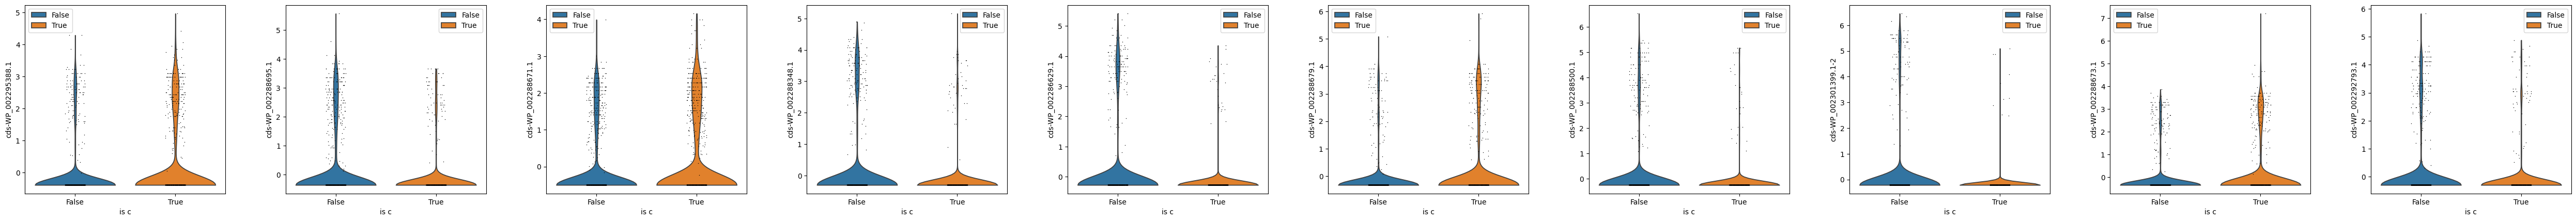

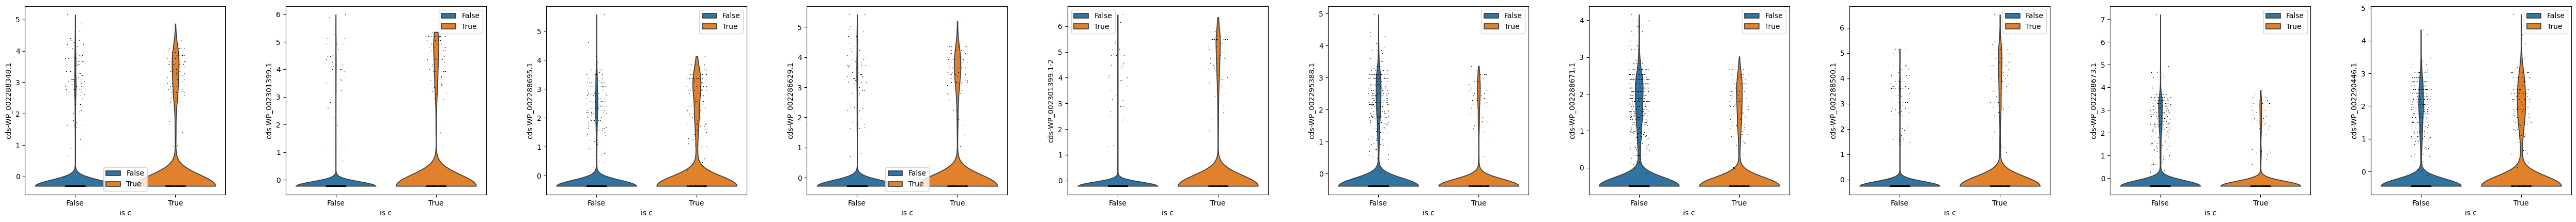

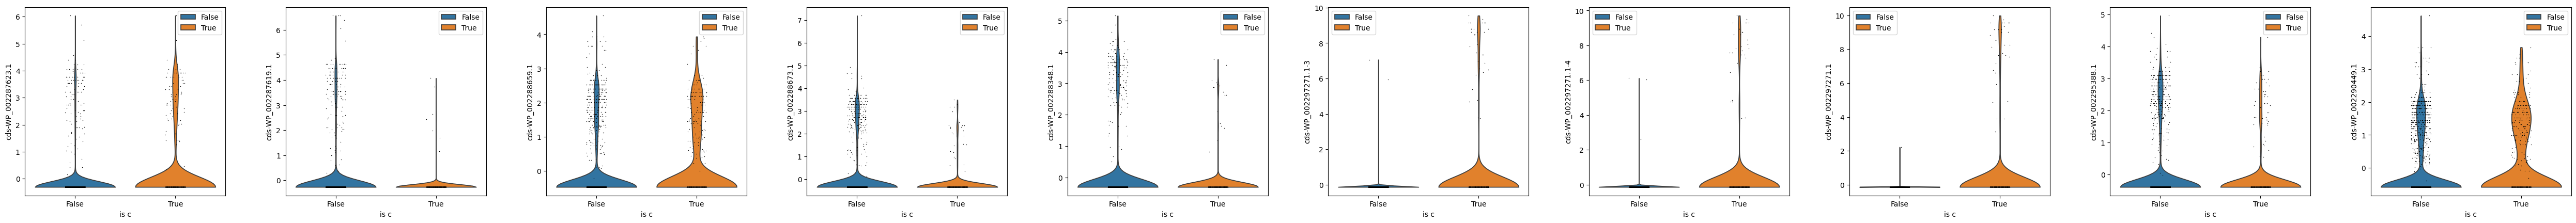

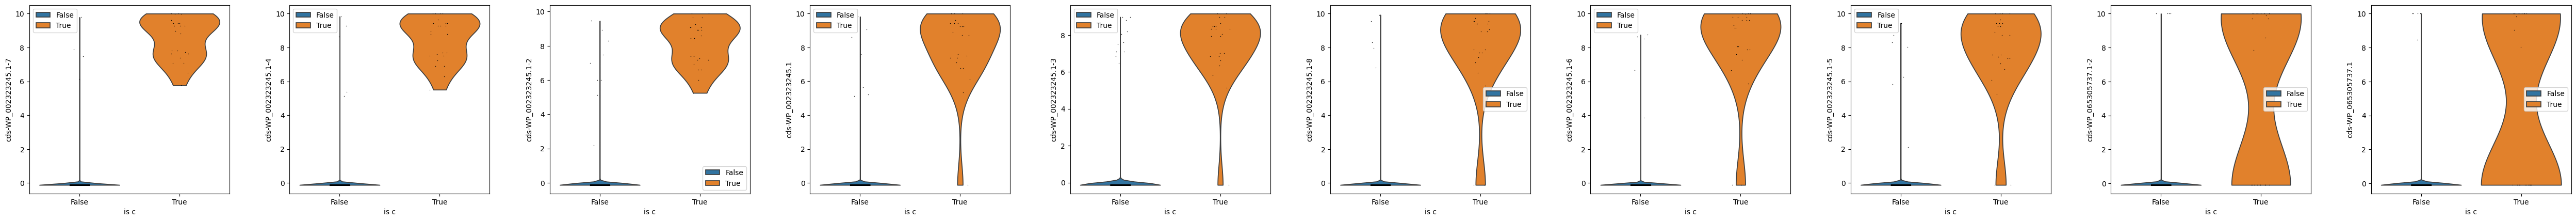

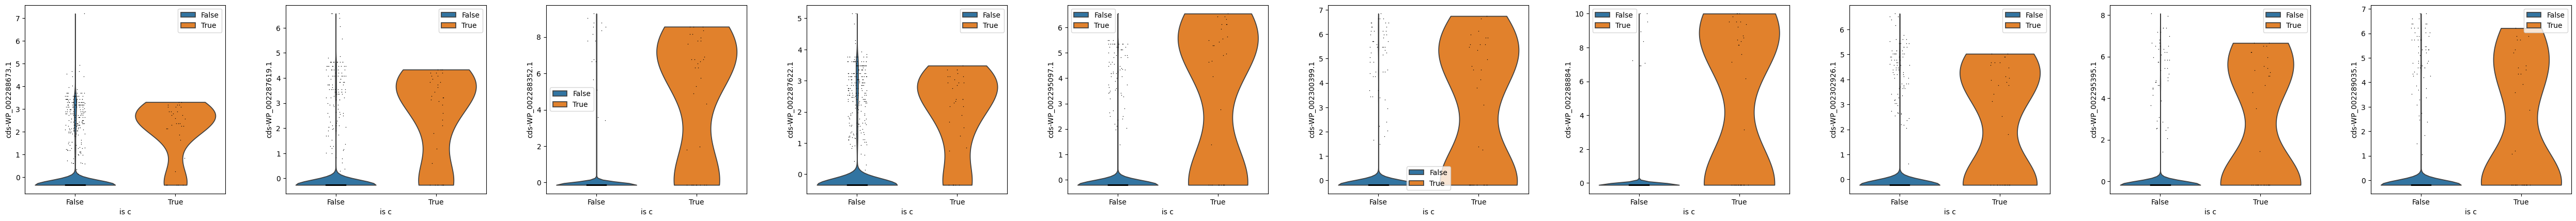

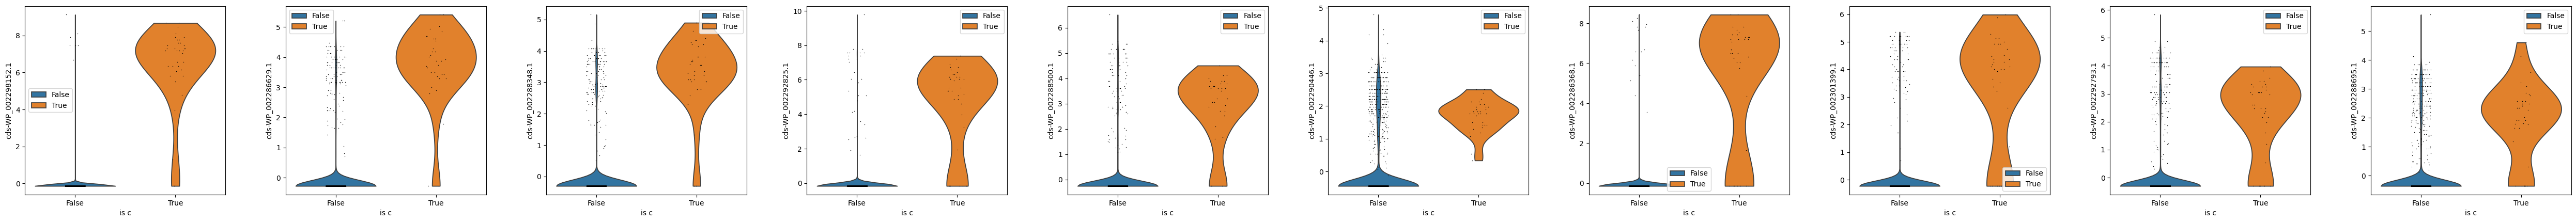

In [29]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [30]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,means,variances,variances_norm,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-FCF09_RS00685,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01380,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01405,14,0.006626,0.006604,99.337435,14.0,2.708050,14,0.006582,False,0.308029,...,0.006626,0.006585,0.961788,0.006626,0.006582,4.389925e-05,poi,0.006638,inf,0.002661
cds-FCF09_RS01745,8,0.003786,0.003779,99.621391,8.0,2.197225,8,0.003772,False,0.179019,...,0.003786,0.003774,0.972293,0.003786,0.003772,1.433445e-05,poi,0.004754,inf,0.204965
cds-FCF09_RS02225,29,0.014198,0.014098,98.627544,30.0,3.433987,29,0.014943,False,0.435907,...,0.014198,0.014950,1.007335,0.014198,0.014943,-7.449434e-04,nb,0.014198,0.258519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-WP_162166412.1,3,0.001420,0.001419,99.858022,3.0,1.386294,3,0.001418,False,0.070689,...,0.001420,0.001418,0.987596,0.001420,0.001418,2.015782e-06,poi,0.006547,inf,0.782912
cds-WP_162166413.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171002443.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171918352.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488


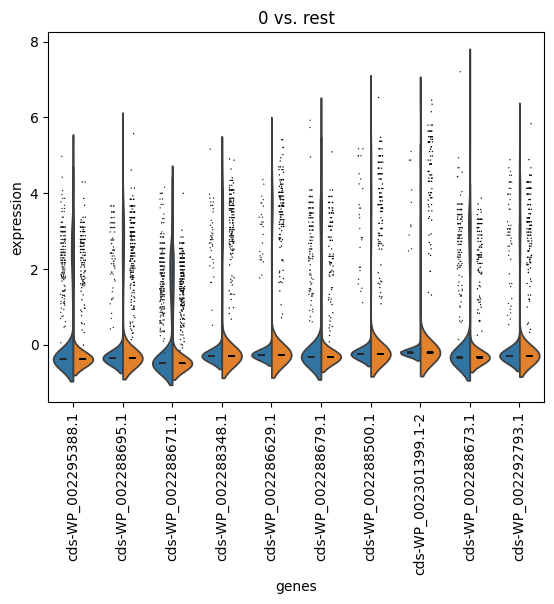

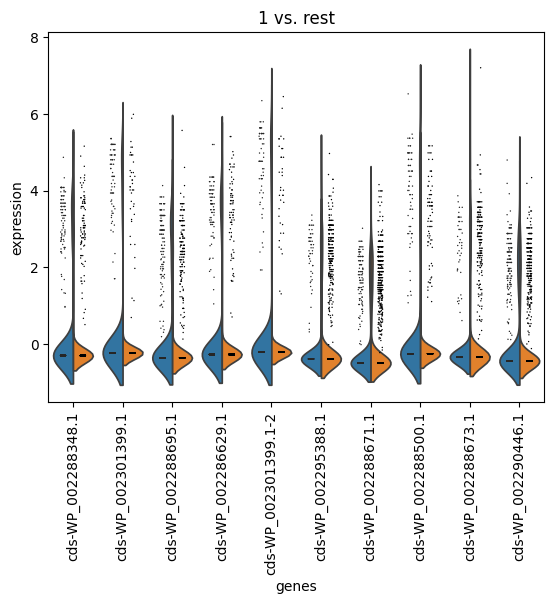

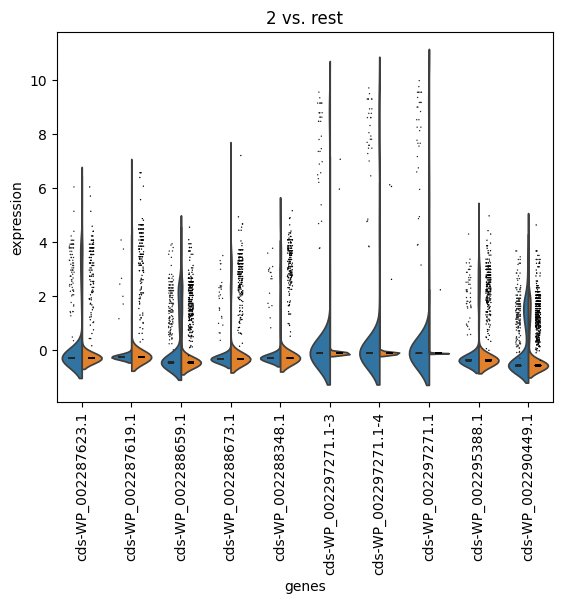

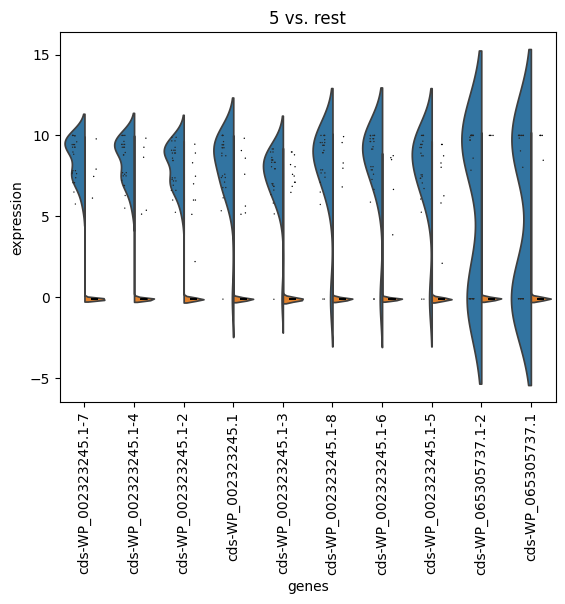

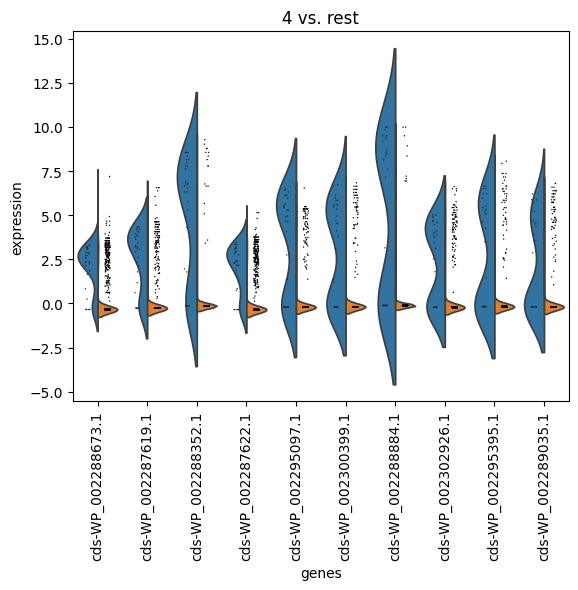

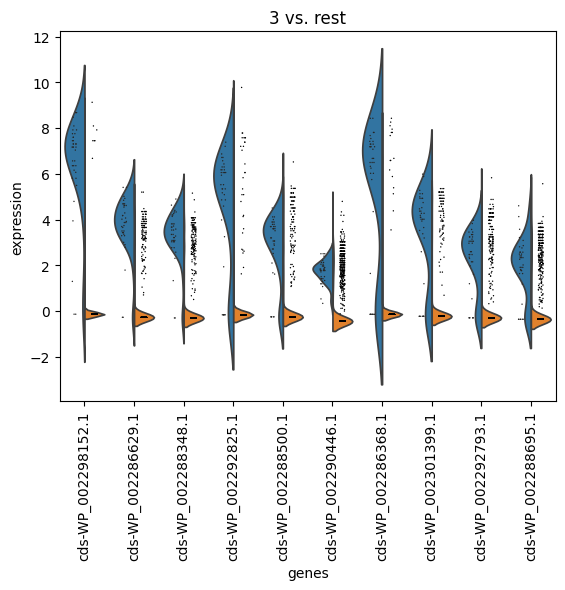

In [31]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [32]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,means,variances,variances_norm,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-FCF09_RS00685,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01380,5,0.002366,0.002364,99.763370,5.0,1.791759,5,0.002361,False,0.111239,...,0.002366,0.002362,0.979956,0.002366,0.002361,5.599394e-06,poi,0.009532,inf,0.751310
cds-FCF09_RS01405,14,0.006626,0.006604,99.337435,14.0,2.708050,14,0.006582,False,0.308029,...,0.006626,0.006585,0.961788,0.006626,0.006582,4.389925e-05,poi,0.006638,inf,0.002661
cds-FCF09_RS01745,8,0.003786,0.003779,99.621391,8.0,2.197225,8,0.003772,False,0.179019,...,0.003786,0.003774,0.972293,0.003786,0.003772,1.433445e-05,poi,0.004754,inf,0.204965
cds-FCF09_RS02225,29,0.014198,0.014098,98.627544,30.0,3.433987,29,0.014943,False,0.435907,...,0.014198,0.014950,1.007335,0.014198,0.014943,-7.449434e-04,nb,0.014198,0.258519,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-WP_162166412.1,3,0.001420,0.001419,99.858022,3.0,1.386294,3,0.001418,False,0.070689,...,0.001420,0.001418,0.987596,0.001420,0.001418,2.015782e-06,poi,0.006547,inf,0.782912
cds-WP_162166413.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171002443.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488
cds-WP_171918352.1,2,0.000947,0.000946,99.905348,2.0,1.098612,2,0.000946,False,0.051545,...,0.000947,0.000946,0.993402,0.000947,0.000946,8.959030e-07,poi,0.004878,inf,0.805488


In [33]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 0


KeyError: "None of [Index(['locus_tag', 'name', 'symbol'], dtype='object')] are in the [columns]"

In [ ]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)